In [4]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from datetime import datetime
import warnings
import os
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [26]:
class DataExplorer:
    
    def __init__(self, data_path):
        self.data_path = Path(data_path)
        self.behaviors_df = None
        self.news_df = None
        self.entity_embeddings = None
        self.relation_embeddings = None

    def load_data(self):
        print("Loading MIND Dataset")

        # Load behaviors.tsv
        behaviors_path = self.data_path / "behaviors.tsv"
        self.behaviors_df = pd.read_csv(behaviors_path, sep='\t', header = None, names=['impression_id', 'user_id', 'timestamp', 'history', 'impressions'])
        
        # Load news.tsv
        news_path = self.data_path / "news.tsv"
        self.news_df = pd.read_csv(news_path, sep='\t', header= None, names=['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities'])
        
        # Load embeddings
        entity_path = self.data_path / "entity_embedding.vec"
        self.entity_embeddings = self._load_embeddings(entity_path)
        
        relation_path = self.data_path / "relation_embedding.vec"
        self.relation_embeddings = self._load_embeddings(relation_path)

        print(f'Embeddings Loaded')
        print(f'{len(self.behaviors_df): ,} behavior entities')
        print(f'{len(self.news_df): ,} news articles')
        print(f'{len(self.entity_embeddings): ,} entity embedding')
        print(f'{len(self.relation_embeddings): ,} relation embedding')

    
    def _load_embeddings(self, file_path):
        """Load embeddings from .vec files"""
        embeddings = {}
        with open(file_path, 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) >= 2:
                    entity_id = parts[0]
                    embedding = [float(x) for x in parts[1].split()]
                    embeddings[entity_id] = np.array(embedding)
        return embeddings

In [27]:
explorer = DataExplorer("data/mind/MINDsmall_train/")
explorer.load_data()

Loading MIND Dataset
Embeddings Loaded
 156,965 behavior entities
 51,282 news articles
 26,904 entity embedding
 1,091 relation embedding


In [28]:
#Dataset Overview

print("\n DATASET OVERVIEW")
print("=" * 50)

print(f"Behaviors Size: {explorer.behaviors_df.shape}")
print(f"News Size: {explorer.news_df.shape}")
print(f"Unique Users: {explorer.behaviors_df['user_id'].nunique():,}")
print(f"Unique News Articles: {explorer.news_df['news_id'].nunique():,}")

print("\n Sample Behaviors Data:")
display(explorer.behaviors_df.head())

print("\n Sample News Data:")
display(explorer.news_df.head())


 DATASET OVERVIEW
Behaviors Size: (156965, 5)
News Size: (51282, 8)
Unique Users: 50,000
Unique News Articles: 51,282

 Sample Behaviors Data:


,impression_id,user_id,timestamp,history,impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...



 Sample News Data:


,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."



 USER BEHAVIOR ANALYSIS
User Activity Statistics:
count    50000.000000
mean         3.139300
std          3.001026
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         62.000000
Name: total_impressions, dtype: float64


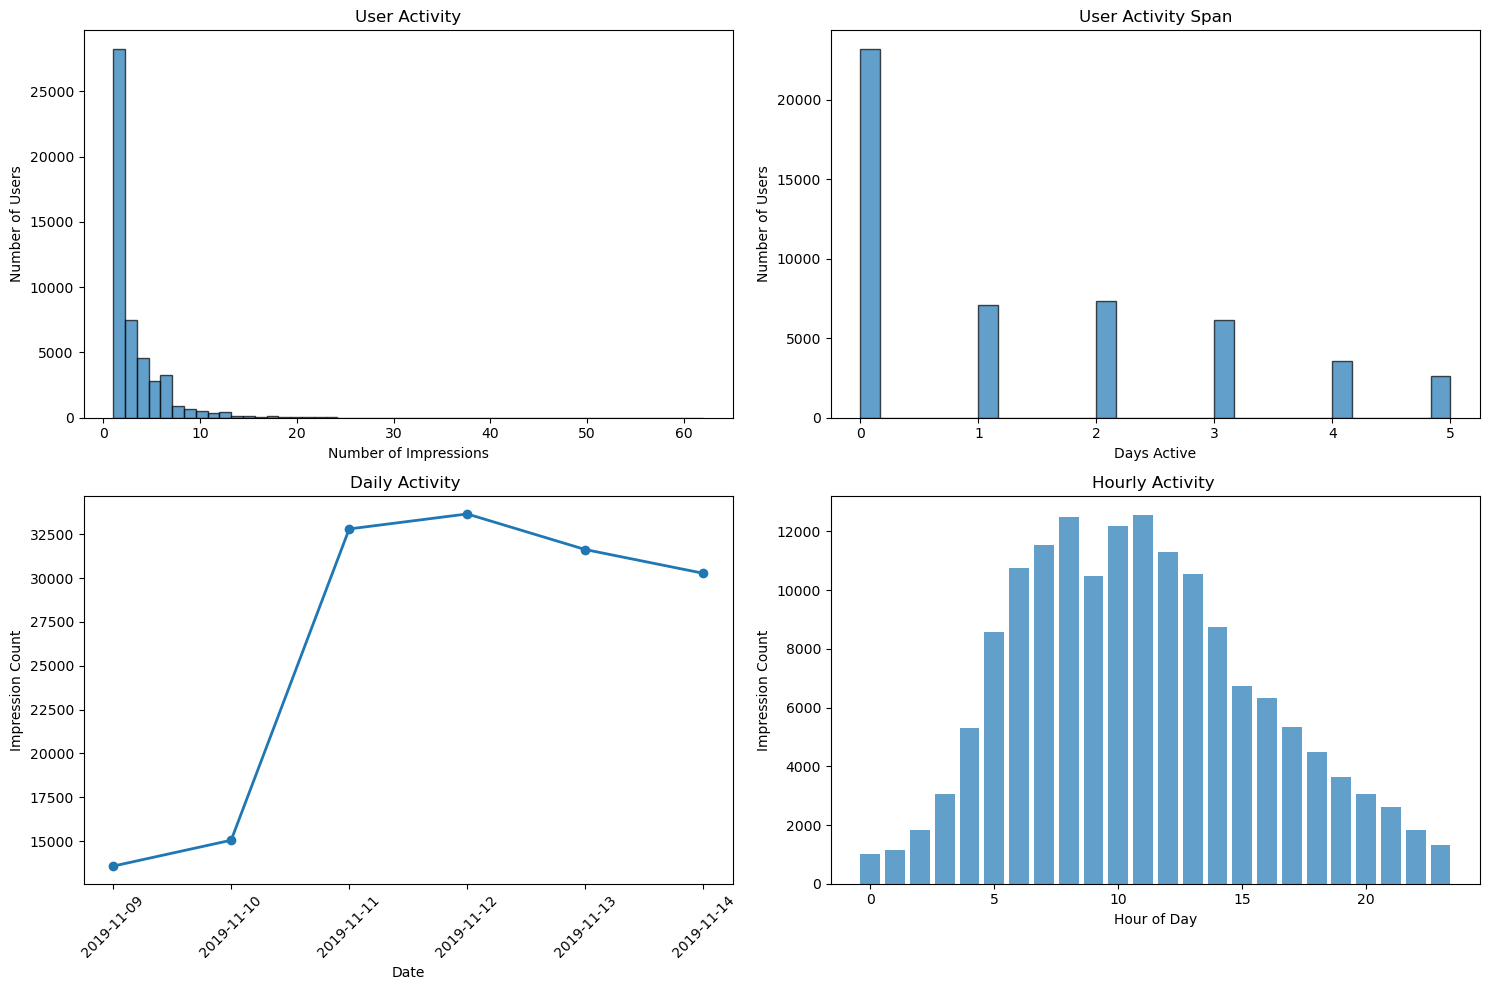

In [29]:
#User Behavior Analysis

print("\n USER BEHAVIOR ANALYSIS")
print("=" * 50)

explorer.behaviors_df['timestamp'] = pd.to_datetime(explorer.behaviors_df['timestamp'])

# user statistics
user_stats = explorer.behaviors_df.groupby('user_id').agg({
    'impression_id': 'count',
    'timestamp': ['min', 'max']
}).round(2)
user_stats.columns = ['total_impressions', 'first_activity', 'last_activity']
user_stats['activity_span_days'] = (user_stats['last_activity'] - user_stats['first_activity']).dt.days

print(f"User Activity Statistics:")
print(user_stats['total_impressions'].describe())

# Visualize user activity 
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# User activity 
axes[0,0].hist(user_stats['total_impressions'], bins=50, edgecolor='black', alpha=0.7)
axes[0,0].set_title('User Activity')
axes[0,0].set_xlabel('Number of Impressions')
axes[0,0].set_ylabel('Number of Users')

# User activity span
axes[0,1].hist(user_stats['activity_span_days'], bins=30, edgecolor='black', alpha=0.7)
axes[0,1].set_title('User Activity Span')
axes[0,1].set_xlabel('Days Active')
axes[0,1].set_ylabel('Number of Users')

# activity pattern
daily_activity = explorer.behaviors_df.groupby(explorer.behaviors_df['timestamp'].dt.date).size()
axes[1,0].plot(daily_activity.index, daily_activity.values, marker='o', linewidth=2)
axes[1,0].set_title('Daily Activity ')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Impression Count')
axes[1,0].tick_params(axis='x', rotation=45)

# Hourly pattern
hourly_activity = explorer.behaviors_df.groupby(explorer.behaviors_df['timestamp'].dt.hour).size()
axes[1,1].bar(hourly_activity.index, hourly_activity.values, alpha=0.7)
axes[1,1].set_title('Hourly Activity ')
axes[1,1].set_xlabel('Hour of Day')
axes[1,1].set_ylabel('Impression Count')

plt.tight_layout()
plt.show()



 NEWS CONTENT ANALYSIS
News Categories:
category
news             15774
sports           14510
finance           3107
foodanddrink      2551
lifestyle         2479
travel            2350
video             2068
weather           2048
health            1885
autos             1639
tv                 889
music              769
movies             606
entertainment      587
kids                17
middleeast           2
northamerica         1
Name: count, dtype: int64


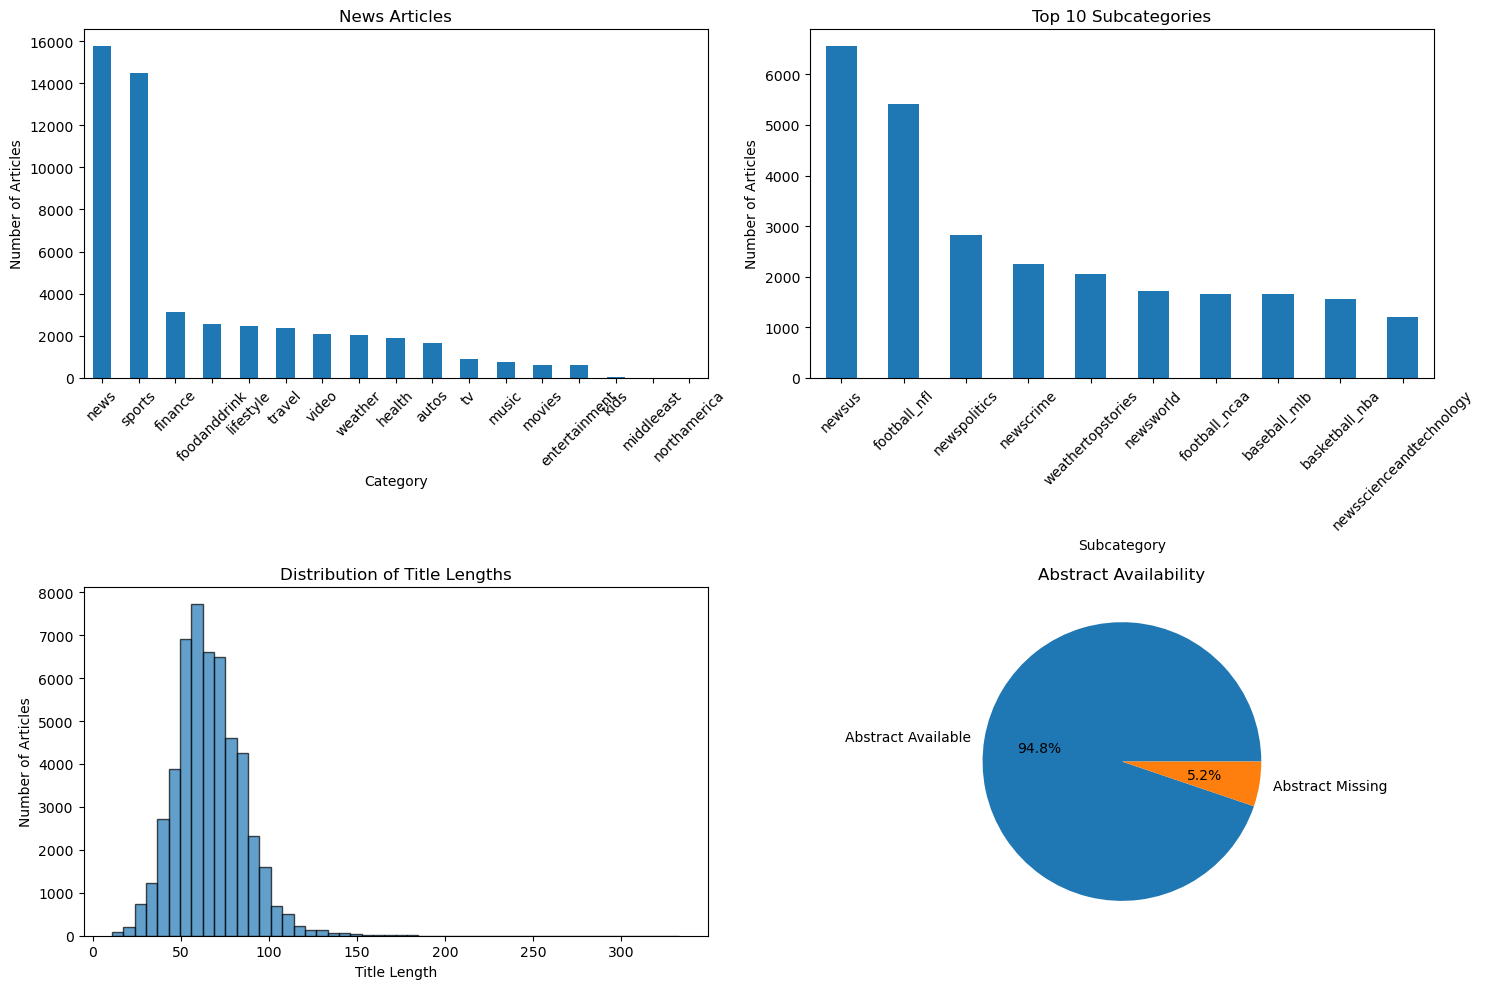

In [30]:
# News Content Analysis

print("\n NEWS CONTENT ANALYSIS")
print("=" * 50)

# Category distribution
category_counts = explorer.news_df['category'].value_counts()
print("News Categories:")
print(category_counts)

# Visualize category 
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Category distribution
category_counts.plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('News Articles')
axes[0,0].set_xlabel('Category')
axes[0,0].set_ylabel('Number of Articles')
axes[0,0].tick_params(axis='x', rotation=45)

# Subcategory distribution
subcategory_counts = explorer.news_df['subcategory'].value_counts().head(10)
subcategory_counts.plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Top 10 Subcategories')
axes[0,1].set_xlabel('Subcategory')
axes[0,1].set_ylabel('Number of Articles')
axes[0,1].tick_params(axis='x', rotation=45)

# Title length distribution
title_lengths = explorer.news_df['title'].str.len()
axes[1,0].hist(title_lengths, bins=50, edgecolor='black', alpha=0.7)
axes[1,0].set_title('Distribution of Title Lengths')
axes[1,0].set_xlabel('Title Length')
axes[1,0].set_ylabel('Number of Articles')

# Abstract availability
abstract_available = explorer.news_df['abstract'].notna().sum()
abstract_missing = explorer.news_df['abstract'].isna().sum()
axes[1,1].pie([abstract_available, abstract_missing], 
              labels=['Abstract Available', 'Abstract Missing'],
              autopct='%1.1f%%')
axes[1,1].set_title('Abstract Availability')

plt.tight_layout()
plt.show()



 ENTITY ANALYSIS
Title Entity Statistics:
count    51282.000000
mean         1.168987
std          0.977183
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          8.000000
Name: title_entity_list, dtype: float64

Abstract Entity Statistics:
count    51282.000000
mean         1.858527
std          1.822684
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         30.000000
Name: abstract_entity_list, dtype: float64


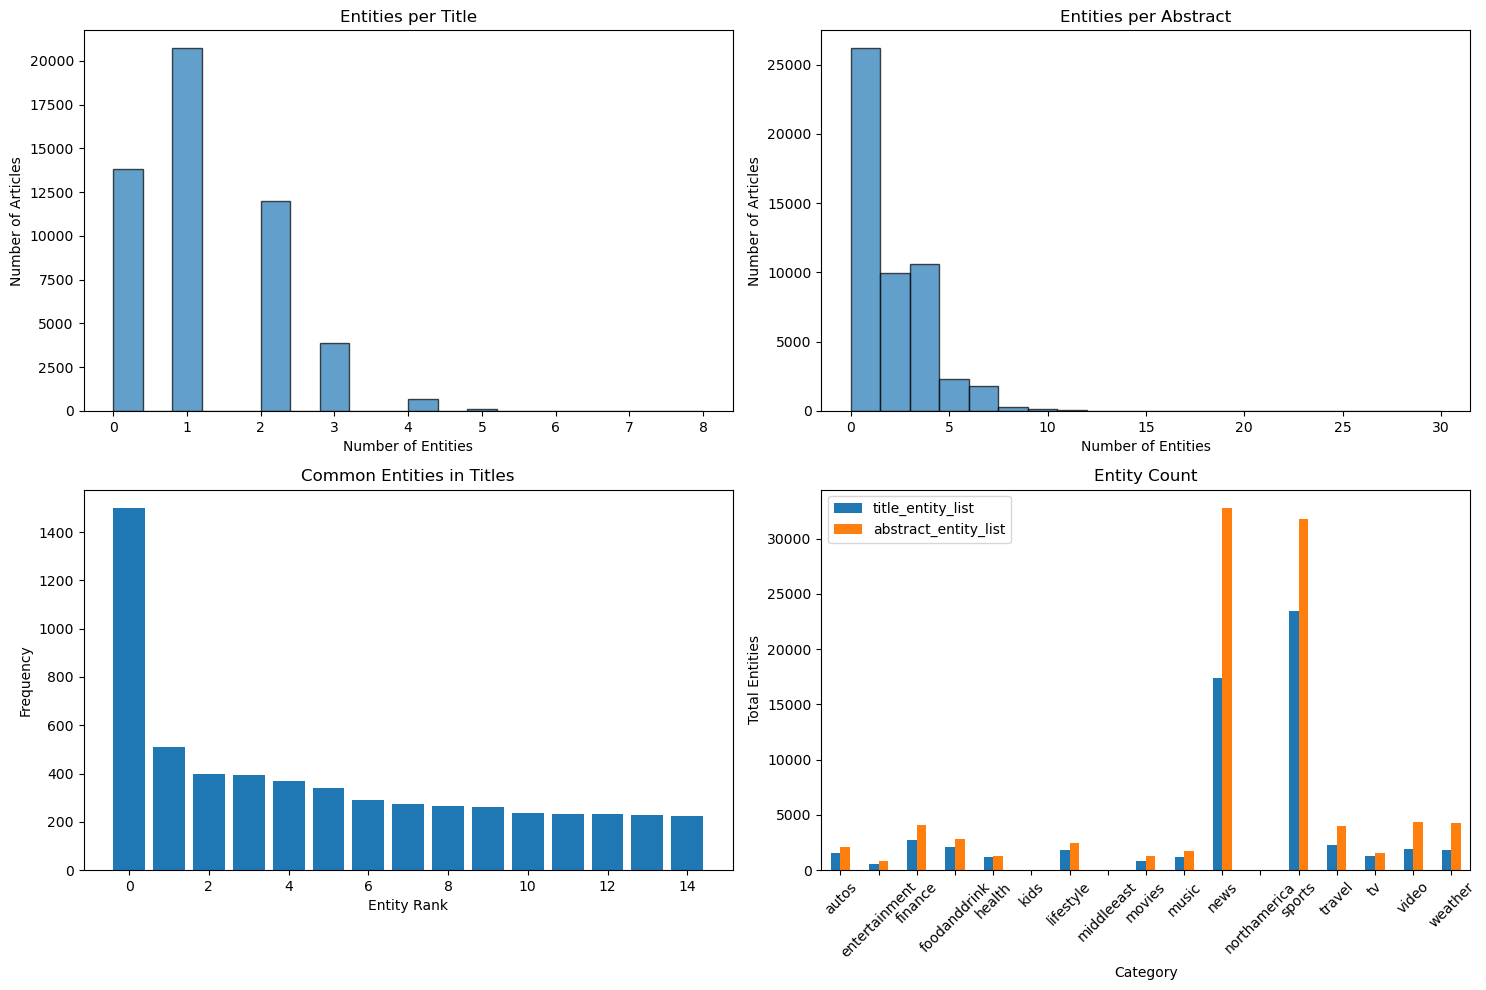

In [31]:
# Entity Analysis


print("\n ENTITY ANALYSIS")
print("=" * 50)

# entity information
def parse_entities(entity_str):
    """Parse entity JSON string"""
    if pd.isna(entity_str):
        return []
    try:
        entities = json.loads(entity_str)
        return [entity.get('WikidataId', '') for entity in entities if entity.get('WikidataId')]
    except:
        return []

# Extract entities from titles and abstracts
explorer.news_df['title_entity_list'] = explorer.news_df['title_entities'].apply(parse_entities)
explorer.news_df['abstract_entity_list'] = explorer.news_df['abstract_entities'].apply(parse_entities)

# Entity statistics
title_entity_counts = explorer.news_df['title_entity_list'].apply(len)
abstract_entity_counts = explorer.news_df['abstract_entity_list'].apply(len)

print(f"Title Entity Statistics:")
print(title_entity_counts.describe())
print(f"\nAbstract Entity Statistics:")
print(abstract_entity_counts.describe())

# Visualize entity distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Entities per title
axes[0,0].hist(title_entity_counts, bins=20, edgecolor='black', alpha=0.7)
axes[0,0].set_title('Entities per Title')
axes[0,0].set_xlabel('Number of Entities')
axes[0,0].set_ylabel('Number of Articles')

# Entities per abstract
axes[0,1].hist(abstract_entity_counts, bins=20, edgecolor='black', alpha=0.7)
axes[0,1].set_title('Entities per Abstract')
axes[0,1].set_xlabel('Number of Entities')
axes[0,1].set_ylabel('Number of Articles')

# Most common entities in titles
all_title_entities = [entity for entities in explorer.news_df['title_entity_list'] for entity in entities]
title_entity_freq = Counter(all_title_entities)
top_title_entities = dict(title_entity_freq.most_common(15))

axes[1,0].bar(range(len(top_title_entities)), list(top_title_entities.values()))
axes[1,0].set_title('Common Entities in Titles')
axes[1,0].set_xlabel('Entity Rank')
axes[1,0].set_ylabel('Frequency')

# Entity coverage across categories
entity_by_category = explorer.news_df.groupby('category').agg({
    'title_entity_list': lambda x: sum(len(entities) for entities in x),
    'abstract_entity_list': lambda x: sum(len(entities) for entities in x)
})
entity_by_category.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Entity Count')
axes[1,1].set_xlabel('Category')
axes[1,1].set_ylabel('Total Entities')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


 INTERACTION PATTERN ANALYSIS
Overall Click Rate: 0.0404 (4.04%)

Impression Pattern Statistics:
Average impressions per session: 37.23
Average clicks per session: 1.51


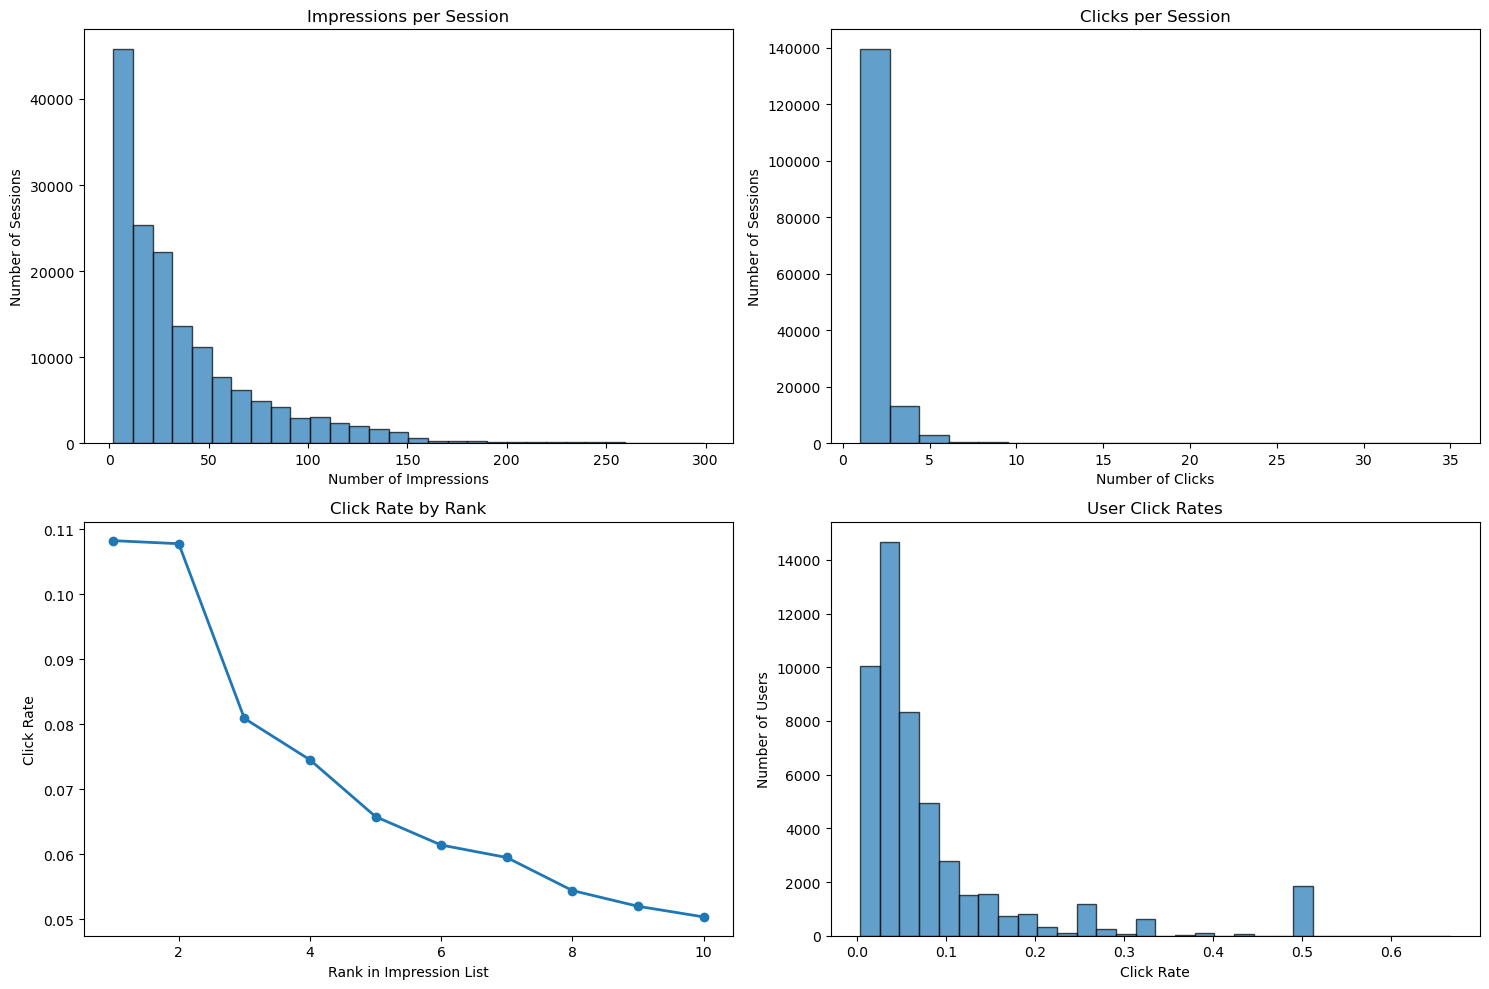

In [32]:
# INTERACTION PATTERN ANALYSIS


print("\n INTERACTION PATTERN ANALYSIS")
print("=" * 50)

# impression data
def parse_impressions(impression_str):
    """ impression string to extract news IDs and click labels"""
    if pd.isna(impression_str):
        return [], []
    
    impressions = impression_str.split()
    news_ids = []
    clicks = []
    
    for item in impressions:
        if '-' in item:
            news_id, click = item.split('-')
            news_ids.append(news_id)
            clicks.append(int(click))
        else:
            news_ids.append(item)
            clicks.append(0)
    
    return news_ids, clicks

# Parse impression data
impression_data = explorer.behaviors_df['impressions'].apply(parse_impressions)
explorer.behaviors_df['impression_news_ids'] = impression_data.apply(lambda x: x[0])
explorer.behaviors_df['impression_clicks'] = impression_data.apply(lambda x: x[1])

# Calculate click-through rates
total_impressions = sum(len(clicks) for clicks in explorer.behaviors_df['impression_clicks'])
total_clicks = sum(sum(clicks) for clicks in explorer.behaviors_df['impression_clicks'])
overall_ctr = total_clicks / total_impressions if total_impressions > 0 else 0

print(f"Overall Click Rate: {overall_ctr:.4f} ({overall_ctr*100:.2f}%)")

# Analyze impression patterns
impressions_per_session = explorer.behaviors_df['impression_news_ids'].apply(len)
clicks_per_session = explorer.behaviors_df['impression_clicks'].apply(sum)

print(f"\nImpression Pattern Statistics:")
print(f"Average impressions per session: {impressions_per_session.mean():.2f}")
print(f"Average clicks per session: {clicks_per_session.mean():.2f}")

# Visualize interaction patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Impressions per session
axes[0,0].hist(impressions_per_session, bins=30, edgecolor='black', alpha=0.7)
axes[0,0].set_title('Impressions per Session')
axes[0,0].set_xlabel('Number of Impressions')
axes[0,0].set_ylabel('Number of Sessions')

# Clicks per session
axes[0,1].hist(clicks_per_session, bins=20, edgecolor='black', alpha=0.7)
axes[0,1].set_title('Clicks per Session')
axes[0,1].set_xlabel('Number of Clicks')
axes[0,1].set_ylabel('Number of Sessions')

# Click rate by rank
position_ctr = []
for i in range(min(10, impressions_per_session.max())):
    position_clicks = []
    position_impressions = []
    
    for clicks in explorer.behaviors_df['impression_clicks']:
        if len(clicks) > i:
            position_clicks.append(clicks[i])
            position_impressions.append(1)
    
    if position_impressions:
        ctr = sum(position_clicks) / sum(position_impressions)
        position_ctr.append(ctr)

axes[1,0].plot(range(1, len(position_ctr) + 1), position_ctr, marker='o', linewidth=2)
axes[1,0].set_title('Click Rate by Rank')
axes[1,0].set_xlabel('Rank in Impression List')
axes[1,0].set_ylabel('Click Rate')

# User engagement levels
user_engagement = explorer.behaviors_df.groupby('user_id').agg({
    'impression_clicks': lambda x: sum(sum(clicks) for clicks in x),
    'impression_news_ids': lambda x: sum(len(ids) for ids in x)
})
user_engagement['ctr'] = user_engagement['impression_clicks'] / user_engagement['impression_news_ids']

axes[1,1].hist(user_engagement['ctr'], bins=30, edgecolor='black', alpha=0.7)
axes[1,1].set_title('User Click Rates')
axes[1,1].set_xlabel('Click Rate')
axes[1,1].set_ylabel('Number of Users')

plt.tight_layout()
plt.show()


⏰ TEMPORAL ANALYSIS


ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of labels (7).

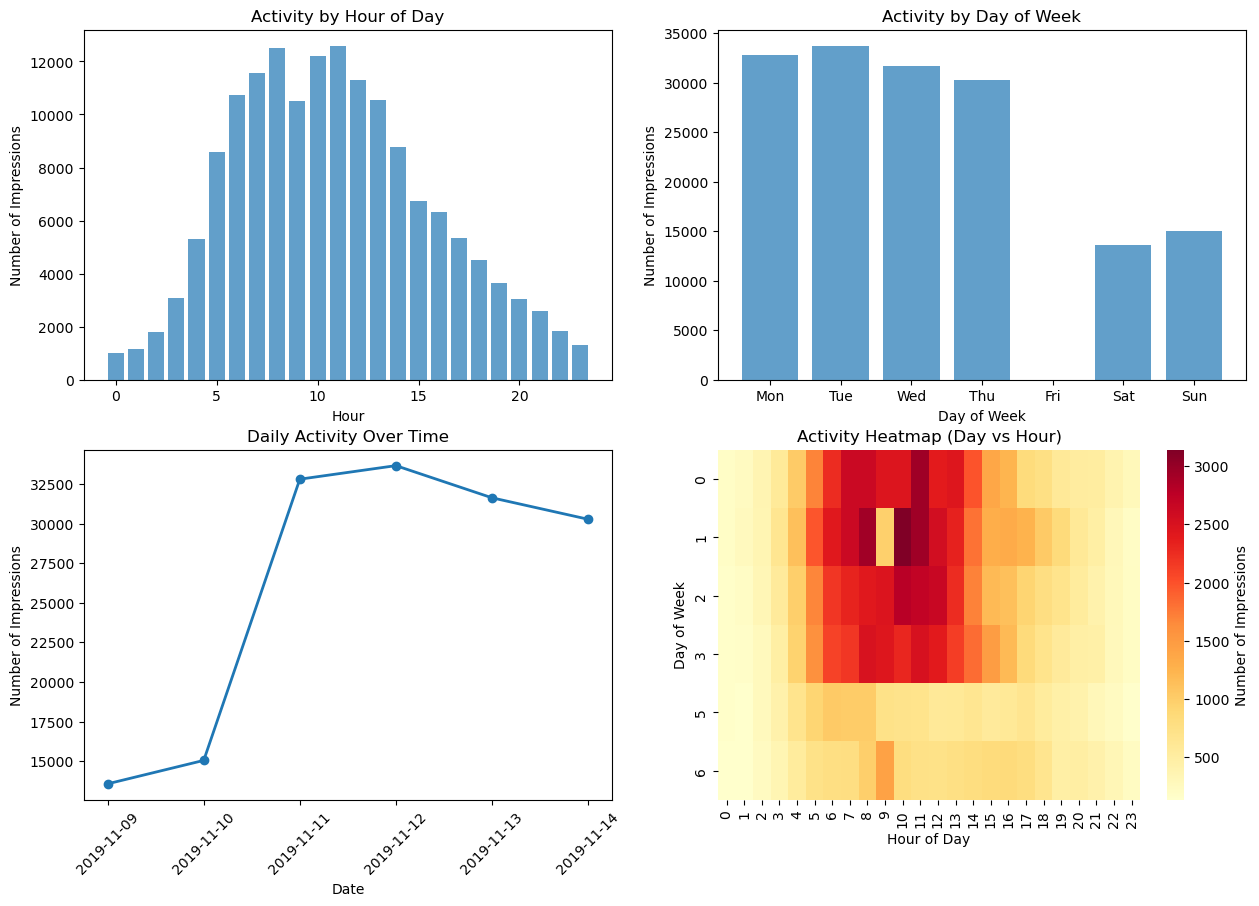

In [33]:
# 7. TEMPORAL ANALYSIS
# =============================================================================

print("\n⏰ TEMPORAL ANALYSIS")
print("=" * 50)

# Time-based patterns
explorer.behaviors_df['hour'] = explorer.behaviors_df['timestamp'].dt.hour
explorer.behaviors_df['day_of_week'] = explorer.behaviors_df['timestamp'].dt.dayofweek
explorer.behaviors_df['date'] = explorer.behaviors_df['timestamp'].dt.date

# Activity patterns by time
hourly_pattern = explorer.behaviors_df.groupby('hour').size()
daily_pattern = explorer.behaviors_df.groupby('day_of_week').size()

# Visualize temporal patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Hourly activity pattern
axes[0,0].bar(hourly_pattern.index, hourly_pattern.values, alpha=0.7)
axes[0,0].set_title('Activity by Hour of Day')
axes[0,0].set_xlabel('Hour')
axes[0,0].set_ylabel('Number of Impressions')

# Daily activity pattern
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0,1].bar(daily_pattern.index, daily_pattern.values, alpha=0.7)
axes[0,1].set_title('Activity by Day of Week')
axes[0,1].set_xlabel('Day of Week')
axes[0,1].set_ylabel('Number of Impressions')
axes[0,1].set_xticks(range(7))
axes[0,1].set_xticklabels(day_names)

# Activity over time
daily_activity = explorer.behaviors_df.groupby('date').size()
axes[1,0].plot(daily_activity.index, daily_activity.values, marker='o', linewidth=2)
axes[1,0].set_title('Daily Activity Over Time')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Number of Impressions')
axes[1,0].tick_params(axis='x', rotation=45)

# Heatmap of activity by hour and day
activity_heatmap = explorer.behaviors_df.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)
sns.heatmap(activity_heatmap, ax=axes[1,1], cmap='YlOrRd', cbar_kws={'label': 'Number of Impressions'})
axes[1,1].set_title('Activity Heatmap (Day vs Hour)')
axes[1,1].set_xlabel('Hour of Day')
axes[1,1].set_ylabel('Day of Week')
axes[1,1].set_yticklabels(day_names)

plt.tight_layout()
plt.show()



🕸️ KNOWLEDGE GRAPH INSIGHTS
Entity embedding dimensions: 1
Embedding statistics (sample of 1000):
  Mean: -0.0044
  Std: 0.0550
  Min: -0.1804
  Max: 0.1915


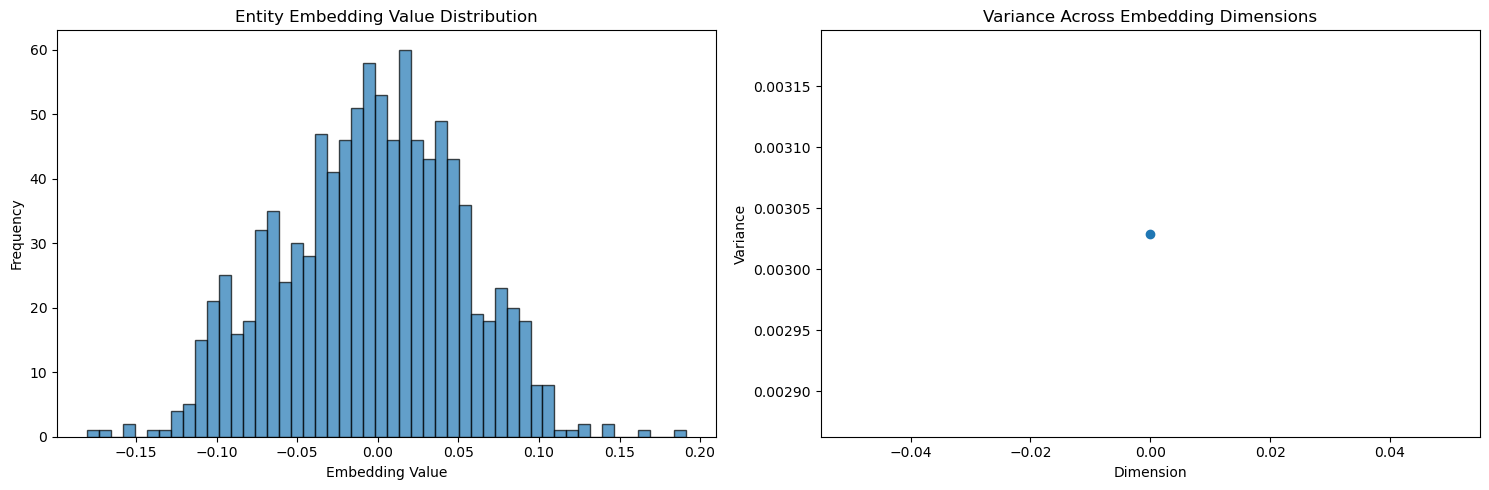

In [34]:
# 8. KNOWLEDGE GRAPH INSIGHTS
# =============================================================================

print("\n🕸️ KNOWLEDGE GRAPH INSIGHTS")
print("=" * 50)

# Entity embedding analysis
if explorer.entity_embeddings:
    embedding_dims = len(list(explorer.entity_embeddings.values())[0])
    print(f"Entity embedding dimensions: {embedding_dims}")
    
    # Sample embedding analysis
    sample_embeddings = list(explorer.entity_embeddings.values())[:1000]
    embedding_matrix = np.array(sample_embeddings)
    
    # Embedding statistics
    print(f"Embedding statistics (sample of 1000):")
    print(f"  Mean: {embedding_matrix.mean():.4f}")
    print(f"  Std: {embedding_matrix.std():.4f}")
    print(f"  Min: {embedding_matrix.min():.4f}")
    print(f"  Max: {embedding_matrix.max():.4f}")
    
    # Visualize embedding distribution
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Embedding value distribution
    axes[0].hist(embedding_matrix.flatten(), bins=50, alpha=0.7, edgecolor='black')
    axes[0].set_title('Entity Embedding Value Distribution')
    axes[0].set_xlabel('Embedding Value')
    axes[0].set_ylabel('Frequency')
    
    # Embedding dimension variance
    dim_variance = np.var(embedding_matrix, axis=0)
    axes[1].plot(range(embedding_dims), dim_variance, marker='o')
    axes[1].set_title('Variance Across Embedding Dimensions')
    axes[1].set_xlabel('Dimension')
    axes[1].set_ylabel('Variance')
    
    plt.tight_layout()
    plt.show()